# Remaining Useful Life (RUL) Estimation from Strain DIC Measurement

This notebook demonstrates the workflow for estimating the remaining useful life (RUL) of a tungsten component using Digital Image Correlation (DIC) strain data.

**Author:** Jayron Sandhu

## Workflow

The process of estimating Remaining Useful Life (RUL) from strain DIC measurements involves the following key steps:

1. **Data Exploration and Statistical Analysis**:
   - Plotting specific points or averaged areas on the surface over time
   - Using statistical tools to identify points of high strain (over time)
   - Determining critical locations for further analysis

2. **Stress Field Conversion**:
   - Converting 2D strain fields to stress fields using tungsten material properties
   - Calculating stress components for each time point in the measurement cycle
   - Evaluating safety factors against yield criteria

3. **Critical Area Selection**:
   - Selecting key areas of the stress field based on previous analysis of high strain
   - Focusing on regions with maximum principal strain and maximum shear strain
   - Identifying locations most susceptible to fatigue failure

4. **Fracture Mechanics and Crack Growth Modeling**:
   - Implementing fracture mechanics principles to model potential crack growth
   - Applying rainflow cycle counting to extract fatigue cycles from strain history
   - Utilizing Manson-Coffin relationship and Miner's rule to calculate cumulative damage

5. **RUL Estimation and Design Code Verification**:
   - Checking against design codes from sources like ITER for maximum allowable crack size or fatigue life limits
   - Calculating RUL based on time per cycle and number of cycles until reaching limits
   - Providing time-based estimates for maintenance planning and component replacement

This approach combines empirical DIC measurements with theoretical models to create a comprehensive analysis workflow that moves from raw strain data to actionable RUL estimates.

## Physics-Based Modelling

### **Principal Strains**
Principal strains represent the maximum and minimum strains at any point, regardless of the measurement direction. They are critical for fatigue analysis because failure typically occurs along these principal directions.

The equation to calculate principal strains from normal strain components is:

$$
\varepsilon_{\max, \min} = \frac{\varepsilon_{xx} + \varepsilon_{yy}}{2} \pm \sqrt{\left( \frac{\varepsilon_{xx} - \varepsilon_{yy}}{2} \right)^2 + \left( \frac{\gamma_{xy}}{2} \right)^2}
$$


Where:
$$
\varepsilon_{\max} = \text{Major principal strain (typically tensile)}
$$  

$$
\varepsilon_{\min} = \text{Minor principal strain (often compressive)}
$$  

$$
\varepsilon_{xx} = \text{Normal strain in the x-direction (from DIC)}
$$  

$$
\varepsilon_{yy} = \text{Normal strain in the y-direction (from DIC)}
$$  

$$
\gamma_{xy} = \text{Shear strain (often assumed zero when not measured by DIC)}
$$  

### Rainflow Counting

Rainflow counting is an algorithm used to identify damaging stress/strain cycles from irregular loading patterns such as the heat flux radiating from a hot plasma.

### Fatigue Estimation using Manson-Coffin Relationship

The Manson-Coffin relationship combines both elastic and plastic strain components to predict fatigue life across low-cycle and high-cycle fatigue regimes.

$$
\frac{\Delta \varepsilon}{2} = \left(\frac{\sigma_f'}{E} \right)(2N_f)^b + \varepsilon_f' (2N_f)^c
$$

Where:

$$
\frac{\Delta \varepsilon}{2} = \text{Strain amplitude from the rainflow count}
$$  

$$
\sigma_f' = \text{Fatigue strength coefficient (1000 MPa for tungsten)}
$$  

$$
E = \text{Young’s modulus (400 GPa)}
$$  

$$
\varepsilon_f' = \text{Fatigue ductility coefficient (0.1 for tungsten)}
$$  

$$
b = \text{Fatigue strength exponent (-0.12)}
$$  

$$
c = \text{Fatigue ductility exponent (-0.7)}
$$  

$$
N_f = \text{Number of cycles to failure}
$$  

### Miner's Rule for Cumulative Damage

Miner's rule allows us to calculate cumulative fatigue damage from variable amplitude loading cycles identified through rainflow counting.

$$
D = \sum \frac{n_i}{N_{f_i}}
$$

Where:

$$
D = \text{Cumulative damage (failure occurs when } D = 1\text{)}
$$  

$$
n_i = \text{Number of applied cycles at a given strain range}
$$  

$$
N_{f_i} = \text{Number of cycles to failure at that strain range (from Manson-Coffin)}
$$  



### How it All Comes Together

- Strain Data is extracted from the DIC data.
- Data Processing is done to extract regions of high strain.
- Principle strains are calculated using these high strains.
- Rainflow counting is used to extract the strain-time history. Rainflow counting outputs strain range, mean strange, and number of occurences. Currently rainflow analyses uses only one maximum point from one column of the data
- Fatigue life calculations are done using Manson Coffin relationship for each strain range outputted from rainflow counting.
- Miners rule is used for damage accumulation for each Manson Coffin strain range.
- Remaining Useful Life can then be calculated depending on current damage and damage rate.
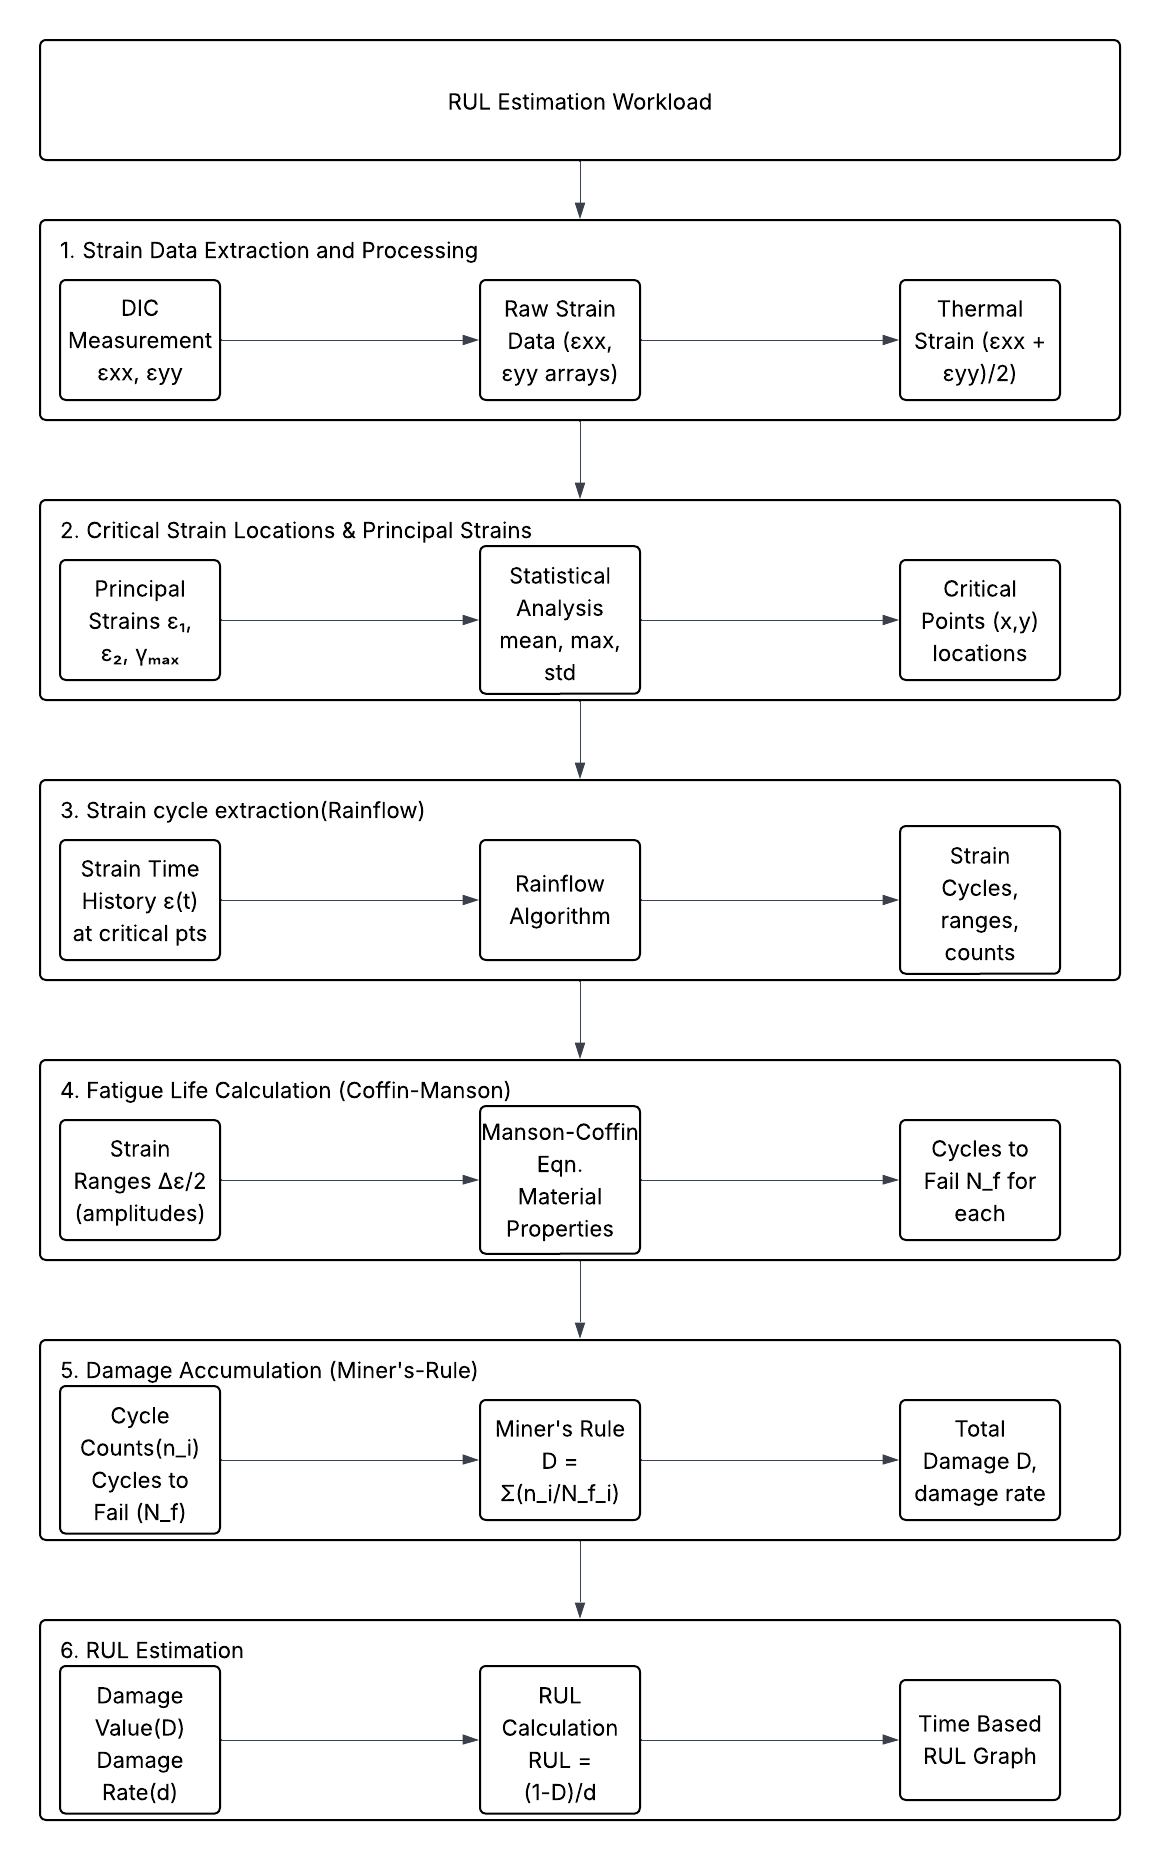




## **0.Setup**

In [1]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import os
import rainflow
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Import modules from our project
from data_loader import load_all_data, print_statistical_summary
from plotter import (plot_initial_strain_analysis, plot_stress_analysis, 
                    plot_strain_analysis, plot_fatigue_analysis_signals,
                    plot_rul_estimation)
from fatigue_analysis import (calculate_stress, calculate_principal_strains,
                             identify_cycles, analyze_fatigue,
                             estimate_fatigue_life)

# Set matplotlib parameters for better visualization
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12

## **1.Strain Data Extraction And Processing**

### **DIC Measurement (εxx, εyy) → Raw Strain Data**

In [2]:

def read_strain_data(strain_type='exx'):
    # File reading logic
    dirDIC = f'/Users/jayron/Downloads/Paper_Data_Set/DIC data/withoutCoil/{strain_type}'
    csv_files = glob.glob(os.path.join(dirDIC, '*.csv'))
    arrays = [pd.read_csv(f, header=None).values for f in csv_files]
    
    # Pad arrays to ensure consistent dimensions
    padded_arrays = [np.pad(arr, 
                           ((0, max_rows - arr.shape[0]), (0, max_cols - arr.shape[1])), 
                           'constant', constant_values=np.nan) 
                    for arr in arrays]
    
    DICData = np.stack(padded_arrays)
    Average = np.nanmean(DICData, axis=0)
    return Average, DICData

### **Raw Strain Data → Thermal Strain (εxx + εyy)/2**

In [3]:
def load_all_data():
    # Load strain data
    AverageExx, DICExx = read_strain_data('exx')
    AverageEyy, DICEyy = read_strain_data('eyy')
    
    # Calculate thermal strain
    ThermalStrain = (DICExx + DICEyy) / 2
    
    # Generate time points
    time_points = np.arange(0, len(ThermalStrain) * 0.2, 0.2)
    
    # Calculate statistical values
    mean_strain = np.nanmean(ThermalStrain, axis=0)
    std_strain = np.nanstd(ThermalStrain, axis=0)
    max_strain = np.nanmax(ThermalStrain, axis=0)
    
    return (AverageExx, DICExx, AverageEyy, DICEyy, ThermalStrain, 
            time_points, mean_strain, std_strain, max_strain, high_strain_points)

## **2. Critical Strain Locations & Principal Strains**

### **Principal Strains (ε₁, ε₂, γₘₐₓ)**

In [4]:
def calculate_principal_strains(ThermalStrain, DICExx, DICEyy):
    # Initialize arrays for principal strains
    major_principal_strain = np.zeros_like(ThermalStrain)  
    minor_principal_strain = np.zeros_like(ThermalStrain)  
    max_shear_strain = np.zeros_like(ThermalStrain)   

    # Calculate principal strains 
    for t in range(ThermalStrain.shape[0]):
        for i in range(ThermalStrain.shape[1]):
            for j in range(ThermalStrain.shape[2]):
                exx, eyy, exy = DICExx[t, i, j], DICEyy[t, i, j], 0
                avg, diff = (exx + eyy) / 2, (exx - eyy) / 2
                radius = np.sqrt(diff**2 + exy**2)
                
                # Store principal strains and shear strain
                major_principal_strain[t, i, j] = avg + radius
                minor_principal_strain[t, i, j] = avg - radius
                max_shear_strain[t, i, j] = radius
    
    return major_principal_strain, minor_principal_strain, max_shear_strain

### **Statistical Analysis → Critical Points (x,y) locations**

In [5]:
def find_extreme_locations(major_principal_strain, minor_principal_strain, max_shear_strain):
    # Find locations efficiently
    max_principal = np.nan_to_num(major_principal_strain[0], nan=-np.inf)
    min_principal = np.nan_to_num(minor_principal_strain[0], nan=np.inf)
    max_shear = np.nan_to_num(max_shear_strain[0], nan=-np.inf)
    
    max_principal_loc = np.unravel_index(np.argmax(max_principal), major_principal_strain[0].shape)
    min_principal_loc = np.unravel_index(np.argmin(min_principal), minor_principal_strain[0].shape)
    max_shear_loc = np.unravel_index(np.argmax(max_shear), max_shear_strain[0].shape)
    
    print(f"Maximum principal strain location: {max_principal_loc}\n"
          f"Minimum principal strain location: {min_principal_loc}\n"
          f"Maximum shear strain location: {max_shear_loc}")
          
    return max_principal_loc, min_principal_loc, max_shear_loc

## **3. Strain Cycle Extraction (Rainflow)**

### **Strain Time History ε(t) at critical pts → Rainflow Algorithm**

In [6]:
def analyze_fatigue(signal, location_name, ax_time):
    # Clean signal by removing NaNs
    signal_clean = np.copy(signal)
    mask = ~np.isnan(signal_clean)
    if not np.any(mask):
        print(f"Warning: All NaN values in signal for {location_name}")
        return None
    
    # Interpolate and plot signal
    indices = np.arange(len(signal_clean))
    signal_clean = np.interp(indices, indices[mask], signal_clean[mask])
    
    # Plot the signal
    ax_time.plot(time_points, signal_clean, '-', label=location_name)
    ax_time.set_xlabel("Time (seconds)", fontsize=13)
    ax_time.set_ylabel("Strain (ε)", fontsize=13)
    ax_time.set_title(f"Strain History - {location_name}", fontsize=15, pad=10)
    
    # Extract cycles using rainflow algorithm
    cycles = rainflow.count_cycles(signal_clean)
    if not cycles:
        print(f"No cycles found for {location_name}")
        return None

### **Rainflow Algorithm → Strain Cycles, ranges, counts**

In [ ]:
# Handle different cycle formats
first_cycle = next(iter(cycles))
if len(first_cycle) == 2:
    cycles_array = np.array([(rng, count) for rng, count in cycles])
    ranges, counts = cycles_array[:, 0], cycles_array[:, 1]
elif len(first_cycle) == 5:
    cycles_array = np.array([(rng, mean, count, i_start, i_end) for rng, mean, count, i_start, i_end in cycles])
    ranges, counts = cycles_array[:, 0], cycles_array[:, 2]
else:
    print(f"Unexpected cycle format: {first_cycle}")
    return None

## **4. Fatigue Life Calculation (Coffin-Manson)**

### **Strain Ranges Δε/2 (amplitudes) → Manson-Coffin Eqn.**

In [ ]:
# Material properties
E_mod, sigma_f_prime, epsilon_f_prime = 400e9, 1000e6, 0.1
b, c, safety_factor = -0.12, -0.7, 10.0

# Calculate fatigue life
N_f_cycles = []
for strain_range in ranges:
    strain_amp = strain_range / 2  # Convert range to amplitude

### **Manson-Coffin Eqn. → Cycles to Fail N_f for each**

In [ ]:
    # Numerical solution
    N_values = np.logspace(1, 10, 1000)  
    elastic_strain = (sigma_f_prime/E_mod) * (2*N_values)**b
    plastic_strain = epsilon_f_prime * (2*N_values)**c
    total_strain = elastic_strain + plastic_strain
    
    # Find closest N and apply safety factor and cap
    N_f = N_values[np.argmin(np.abs(total_strain - strain_amp))] / safety_factor
    N_f_cycles.append(min(N_f, 1e6))  # Cap at 1 million cycles

## **5. Damage Accumulation (Miner's Rule)**

### **Cycle Counts(n_i) Cycles to Fail (N_f) → Miner's Rule D = Σ(n_i/N_f_i)**

In [ ]:
# Process cycles by sorting and calculating damage
sorted_indices = np.argsort(N_f_cycles)
sorted_ranges = ranges[sorted_indices]
sorted_counts = counts[sorted_indices]
sorted_N_f = np.array(N_f_cycles)[sorted_indices]

# Calculate damage metrics using Miner's rule
damage_per_cycle = sorted_counts / sorted_N_f

### **Miner's Rule → Total Damage D, damage rate**

In [ ]:
cumulative_damage = np.cumsum(damage_per_cycle)
avg_damage_rate = np.sum(damage_per_cycle) / np.sum(sorted_counts)

# Calculate damage metrics
damage_per_cycle = [count/N_f for count, N_f in zip(counts, N_f_cycles)]
total_damage = sum(damage_per_cycle)

In [ ]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import os
import rainflow
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Import modules from our project
from data_loader import load_all_data, print_statistical_summary
from plotter import (plot_initial_strain_analysis, plot_stress_analysis, 
                    plot_strain_analysis, plot_fatigue_analysis_signals,
                    plot_rul_estimation)
from fatigue_analysis import (calculate_stress, calculate_principal_strains,
                             identify_cycles, analyze_fatigue,
                             estimate_fatigue_life)

# Set matplotlib parameters for better visualization
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12

## **6. RUL Estimation**

### **Damage Value(D) Damage Rate(d) → RUL Calculation RUL = (1-D)/d**

In [ ]:
# Initial RUL and capping for very high values
initial_rul = 1 / avg_damage_rate if avg_damage_rate > 0 else float('inf')
max_reasonable_life = 100000

if initial_rul > max_reasonable_life:
    print(f"Note: Capping very high initial RUL ({initial_rul:.1f}) to {max_reasonable_life}")
    initial_rul = max_reasonable_life
    scale_factor = initial_rul / rul_cycles[0] if rul_cycles[0] > 0 else 1.0
    rul_cycles = rul_cycles * scale_factor

# Calculate cycle experience and RUL
cycles_experienced = np.cumsum(sorted_counts)
total_cycles = np.sum(sorted_counts)
rul_cycles = np.maximum((1 - cumulative_damage) / avg_damage_rate, 0)

### **RUL Calculation → Time Based RUL Graph**

In [14]:
def plot_rul_estimation(x_rul_e1, y_rul_e1, x_rul_max_shear, y_rul_max_shear, 
                      max_principal_loc, max_shear_loc, time_per_cycle=70.6):
    """
    Plot RUL estimation curves with time-based information.
    
    Args:
        x_rul_e1: X-values for principal strain RUL curve (cycles)
        y_rul_e1: Y-values for principal strain RUL curve (remaining cycles)
        x_rul_max_shear: X-values for shear strain RUL curve (cycles)
        y_rul_max_shear: Y-values for shear strain RUL curve (remaining cycles)
        max_principal_loc: Location of maximum principal strain (tuple)
        max_shear_loc: Location of maximum shear strain (tuple)
        time_per_cycle: Time duration for each cycle in seconds
    """
    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot RUL curves
    ax1.plot(x_rul_e1, y_rul_e1, 'b-', linewidth=2)
    ax2.plot(x_rul_max_shear, y_rul_max_shear, 'r-', linewidth=2)
    
    # Format axes
    for ax, title, loc in zip([ax1, ax2], 
                             ['Principal Strain RUL', 'Shear Strain RUL'],
                             [max_principal_loc, max_shear_loc]):
        ax.set_xlabel('Cycles Experienced', fontsize=14)
        ax.set_ylabel('Remaining Useful Life (cycles)', fontsize=14)
        ax.set_title(f'{title} at Location {loc}', fontsize=16)
        ax.grid(True, alpha=0.3)
    
    # Add time-based information
    if time_per_cycle > 0:
        # Calculate elapsed time for maximum cycles
        max_cycles = max(np.max(x_rul_e1) if len(x_rul_e1) > 0 else 0,
                         np.max(x_rul_max_shear) if len(x_rul_max_shear) > 0 else 0)
        elapsed_time = max_cycles * time_per_cycle  # seconds
        
        # Format elapsed time for display
        if elapsed_time < 60:
            time_str = f"{elapsed_time:.1f} seconds"
        elif elapsed_time < 3600:
            time_str = f"{elapsed_time/60:.1f} minutes"
        else:
            time_str = f"{elapsed_time/3600:.1f} hours"
        
        fig.suptitle(f'RUL Estimation (Max time shown: {time_str})', fontsize=18)
    
    plt.tight_layout()
    plt.show()

## **7. Complete Workflow**

In [15]:
def main():
    # 1. Load and process strain data
    data = load_all_data()
    ThermalStrain = data['thermal_strain']
    DICExx = data['strain_exx']
    DICEyy = data['strain_eyy']
    time_points = data['time_points']
    
    # 2. Calculate principal strains and identify critical locations
    major_principal_strain, minor_principal_strain, max_shear_strain = calculate_principal_strains(
        ThermalStrain, DICExx, DICEyy)
    max_principal_loc, min_principal_loc, max_shear_loc = find_extreme_locations(
        major_principal_strain, minor_principal_strain, max_shear_strain)
    
    # 3. Perform rainflow analysis at critical locations
    cycles_max_strain = analyze_fatigue(
        major_principal_strain[:, max_principal_loc[0], max_principal_loc[1]], 
        f"Max Principal Strain Location {max_principal_loc}",
        plt.figure().add_subplot(111))
    
    cycles_max_shear = analyze_fatigue(
        max_shear_strain[:, max_shear_loc[0], max_shear_loc[1]],
        f"Max Shear Strain Location {max_shear_loc}",
        plt.figure().add_subplot(111))
    
    # 4-5. Calculate fatigue life and accumulate damage
    rul_max_strain, cycles_max_strain_plot = estimate_rul(
        cycles_max_strain, "Max Principal Strain", max_principal_loc,
        plt.figure().add_subplot(111), cycle_multiplier=10)
    
    rul_max_shear, cycles_max_shear_plot = estimate_rul(
        cycles_max_shear, "Max Shear Strain", max_shear_loc,
        plt.figure().add_subplot(111), cycle_multiplier=10)
    
    # 6. Plot RUL estimation
    plot_rul_estimation(
        cycles_max_strain_plot, rul_max_strain,
        cycles_max_shear_plot, rul_max_shear,
        max_principal_loc, max_shear_loc,
        time_per_cycle=70.6)
    
    return 0